In [2]:
from astropy.io import fits
from glob import glob

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from astropy.modeling.models import Gaussian2D
from astropy.table import Table

from matplotlib.axes._axes import Axes
from astropy.visualization import ImageNormalize
from astropy.visualization import ZScaleInterval, LogStretch, SqrtStretch
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve, convolve_fft
from astropy.nddata.utils import Cutout2D
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from photutils.psf import create_matching_kernel
from photutils.psf import TopHatWindow, SplitCosineBellWindow

from multibandphotometry import MultiBandPhotometry

Log:

2023.5.7\
median filter, sysmetry transformation to F814W Disaster. Gaussian filter not change.Found best CosBellwindow parameter.\
Pypher still not useful. Plan to choose fewer sources to create psf.  

In [2]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = MultiBandPhotometry(source_position, z, drop_telescopes=['UKIRT', 'GEMINI', 'SPITZER'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


In [99]:
psfs = {}
for telescope in phot.valid_bands.keys():
    for band in phot.valid_bands[telescope]:
        telescope_band = telescope+'_'+band
        print(telescope_band)
        if telescope == 'JWST':
            #choose 0.05 arcsec/pix to match original image but 0.1 performs better
            with fits.open(f'/home/lupengjun/find_quiescent/WebbPSF/psf/NIRCam_{band.upper()}_25pixels.fits') as hdu:
                psf = hdu[1].data
                pixelscl = hdu[1].header['PIXELSCL']            
        else:
            with fits.open(glob('/home/lupengjun/OII_emitter/photometry/output/PSFinterim/'+f'snap_{telescope_band}*')[0]) as hdu:
                psf = hdu[0].data
                wcs = phot.wcss[telescope_band]
                pixelscl = wcs.proj_plane_pixel_scales()[0].to(u.arcsec).value
        psf = psf/np.sum(psf) #normalization
        psfs[telescope_band] = psf
        hdu = fits.PrimaryHDU(data=psf, )
        hdu.header['PIXSCALE'] = pixelscl
        hdul = fits.HDUList([hdu])
        hdul.writeto(f'/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher/{telescope_band}_psf.fits', overwrite=True)

HST_F606W
HST_F814W
HST_F125W
HST_F160W
JWST_F115W
JWST_F150W
JWST_F277W
JWST_F444W
SUBARU_HSC-G
SUBARU_HSC-I
SUBARU_HSC-R
SUBARU_HSC-Y
SUBARU_HSC-Z
SUBARU_IB0945
SUBARU_NB0387
SUBARU_NB0527
SUBARU_NB0718
SUBARU_NB0816
SUBARU_NB0921
SUBARU_NB0973
CFHT_H
CFHT_i
CFHT_Ks
CFHT_u
VISTA_H
VISTA_J
VISTA_Ks
VISTA_Y
VISTA_NB118


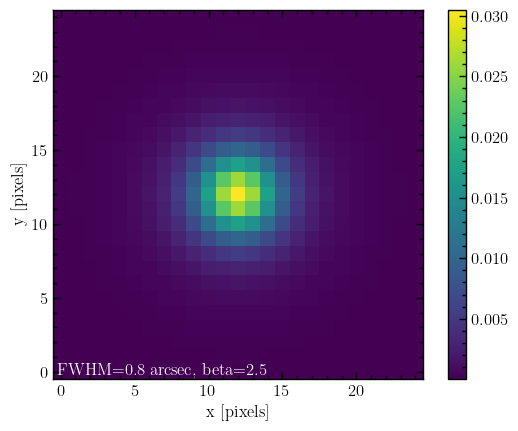

In [8]:
# generate Moffat psf FWHM=0.8 arcsec, beta=2.5, R=5pixels, 
from astropy.convolution import Moffat2DKernel
FWHM_arcsc = 0.8
beta = 2.5
R_arcsec = FWHM_arcsc/np.sqrt(2**(1/beta)-1)/2
R_pix = 4
pixelscl = R_arcsec/R_pix
moffat_2D_kernel = Moffat2DKernel(R_pix, beta, x_size=25, y_size=25)
plt.imshow(moffat_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(0.01, 0.01, f'FWHM={FWHM_arcsc} arcsec, beta={beta}', transform=plt.gca().transAxes, color='w')
plt.colorbar()
plt.show()
# #save to fits
# hdu = fits.PrimaryHDU(data=moffat_2D_kernel.array, )
# hdu.header['PIXSCALE'] = pixelscl
# hdul = fits.HDUList([hdu])
# hdul.writeto(f'/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher/Moffat_profile_psf.fits', overwrite=True)
# psfs['Moffat_profile'] = moffat_2D_kernel.array

In [5]:
xmin, ymin

(-0.5, -0.5)

# generate pypher

In [101]:
kernel_path = '/home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/'
tar_psf_file = '/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher/Moffat_profile_psf.fits'
for file in os.listdir('/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher'):
    if 'Moffat' not in file:
        src_psf_file = '/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher/'+file
        telescope_band = '_'.join(file.split('_')[:2])
        os.system(f'pypher {src_psf_file} {tar_psf_file} {kernel_path}kernel_{telescope_band}_to_Moffat.fits -r 1.e-5')

pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F814W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F125W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F160W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F115W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F150W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F277W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F444W_to_Moffat.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_SUBAR

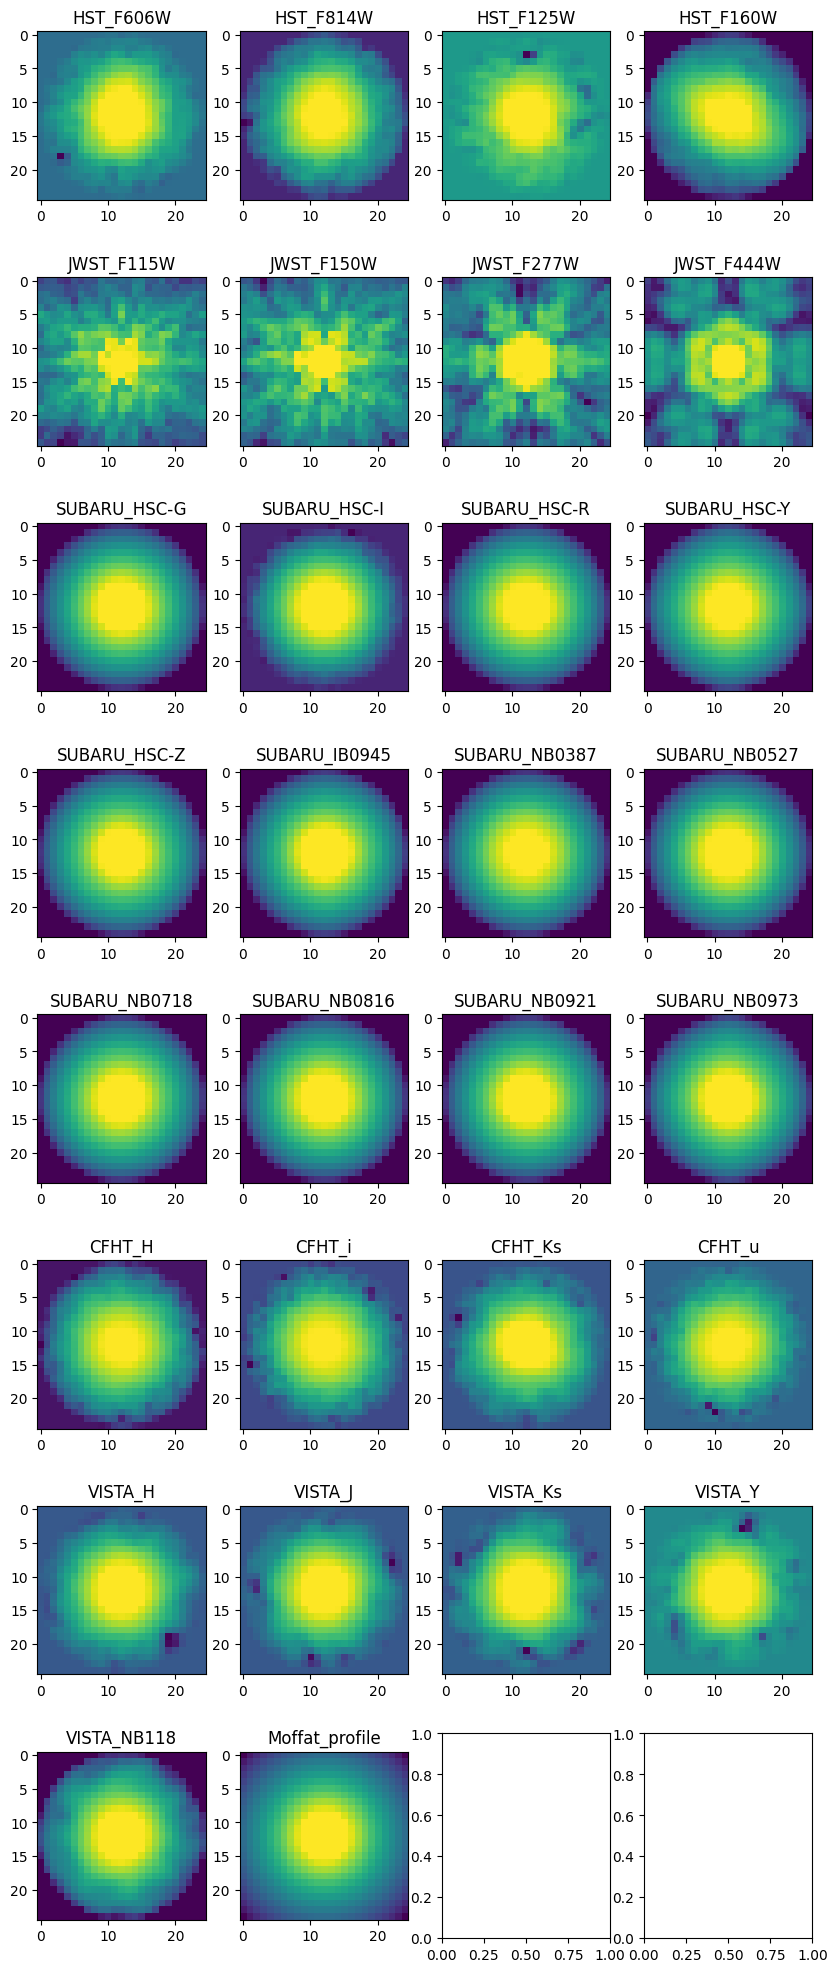

In [93]:
fig, axes = plt.subplots(8,4, figsize=(10,25))
c = -1
for ind, flt in enumerate(psfs):
    psf = psfs[flt]
    norm = ImageNormalize(psf, stretch=LogStretch(), interval=ZScaleInterval(contrast=0.1))
    c += 1
    axes.flatten()[c].imshow(psf, norm=norm,)
    axes.flatten()[c].set_title(flt)
plt.show()

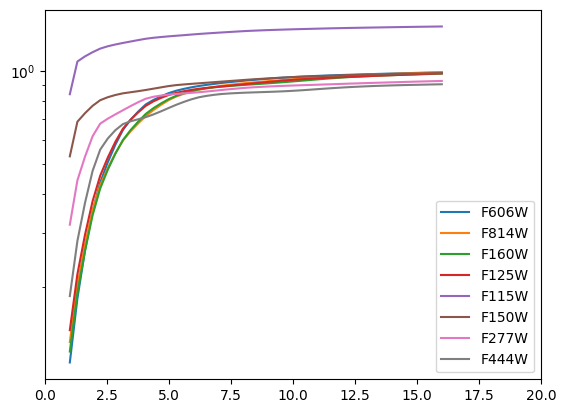

In [13]:
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

def radial_profile(image, bins=50):
    total = np.sum(image)
    center = np.array(image.shape)/2
    
    radii = np.linspace(1, int(image.shape[0]/2), num=bins)
    apertures = [CircularAperture(center, r=r) for r in radii]
    phot_table = aperture_photometry(image, apertures)
    #print(phot_table)
    # convert measurement into array
    return radii, phot_table.to_pandas().values[0][3:]

for ind, (flt, psf) in enumerate(psfs.items()):
    r, profile = radial_profile(psf, bins=50)
    plt.plot(r, profile, label=flt)
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()

In [11]:
def remove_tick(ax):
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

In [104]:
def test_psfmatching(flt, tophat_psf, tophat_kernel, mode, tar_flt='Moffat_profile'):
    #idx = filters.index(flt)
    psf_src = psfs[flt]
    psf_tar = psfs[tar_flt]

    if tophat_psf:
        window = TopHatWindow(1.)
        psf_src = window(psf_src.shape) * psf_src

    kernel = fits.getdata(f'/home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_{flt}_to_Moffat.fits')
    if tophat_kernel:
        window = SplitCosineBellWindow(alpha=1.1, beta=0.2) 
        kernel = window(kernel.shape) * kernel
        
    psf_src_conv = convolve_fft(psf_src, kernel, normalize_kernel=True, allow_huge=True)
    psf_src_conv = psf_src_conv / np.sum(psf_src_conv)

    fig, ax = plt.subplots(3, 2, figsize=(8,8))
    ax_imshow = []

    norm = ImageNormalize(psf_src, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[0][0].imshow(psf_src, norm=norm, cmap='gray'))
    ax[0][0].set_title('before')
    remove_tick(ax[0][0])

    ax_imshow.append(ax[0][1].imshow(psf_src_conv, norm=norm, cmap='gray'))
    ax[0][1].set_title('after')
    remove_tick(ax[0][1])

    norm_k = ImageNormalize(kernel, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[1][0].imshow(kernel, norm=norm_k, cmap='gray'))
    ax[1][0].set_title('kernel')
    remove_tick(ax[1][0])

    ax_imshow.append(ax[1][1].imshow(psf_tar, norm=norm, cmap='gray'))
    ax[1][1].set_title('Moffat')
    remove_tick(ax[1][1])

    res = psf_src_conv-psf_tar
    ax_imshow.append(ax[2][0].imshow(res, norm=norm, cmap='gray'))
    ax[2][0].set_title('residual')
    remove_tick(ax[2][0])

    res = np.abs(psf_src_conv-psf_tar)/psf_tar
    norm_k = ImageNormalize(res, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[2][1].imshow(res, norm=norm_k, cmap='gray'))
    ax[2][1].set_title('residual/Moffat')
    remove_tick(ax[2][1])

    ax_flat = ax.flatten()
    for _ax in ax_flat:
        remove_tick(_ax)
    for _ax in ax_imshow:
        fig.colorbar(_ax)

    title = f'{flt}->Moffat, {mode}'
    if tophat_psf:
        title += ', tophat_psf'
    fig.suptitle(title, fontsize=15) # or plt.suptitle('Main title')
    fig.tight_layout()
    plt.show()
    plt.clf()
    return psf_src_conv

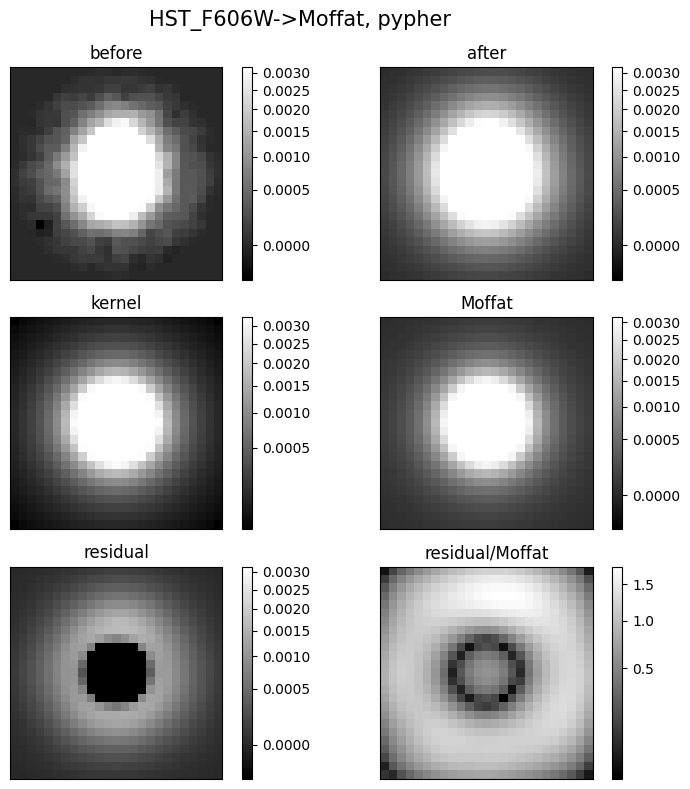

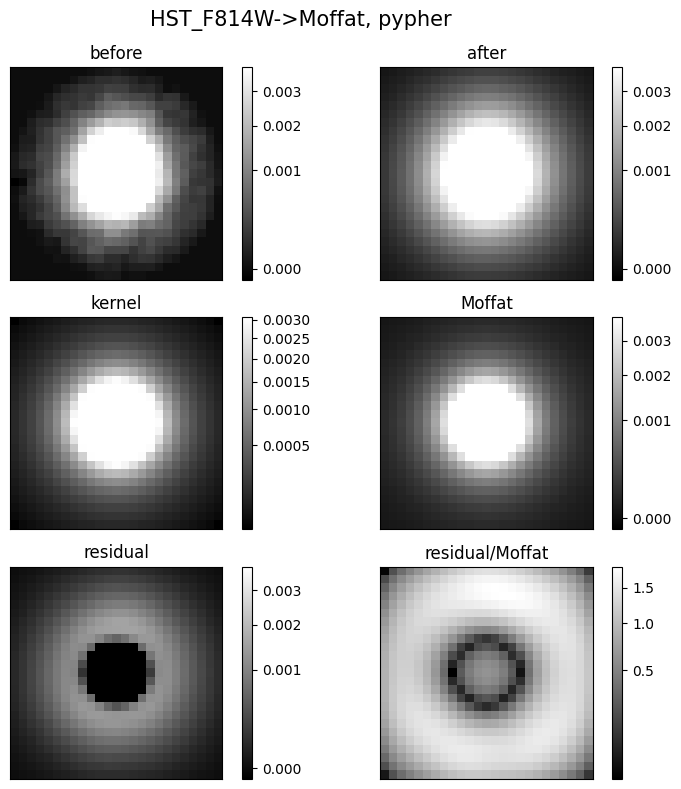

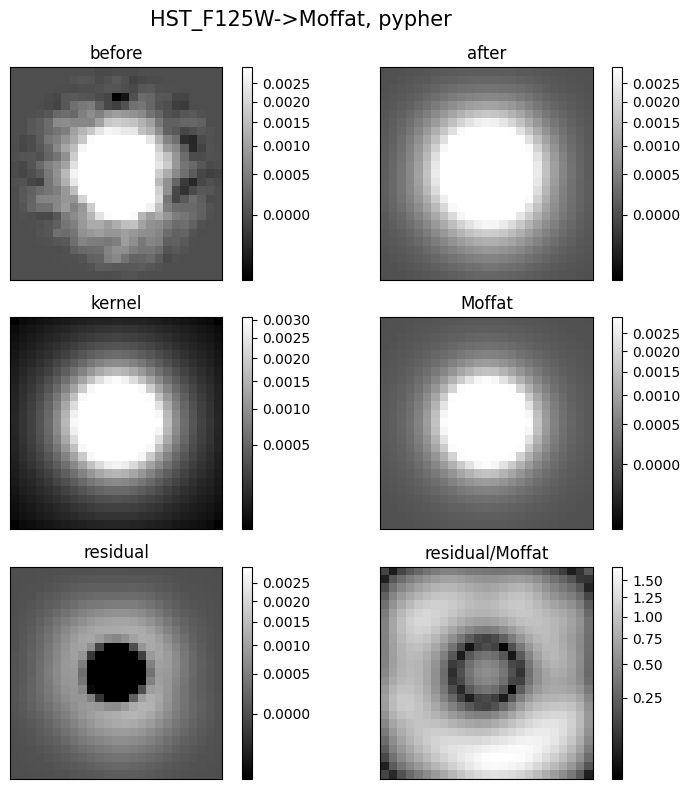

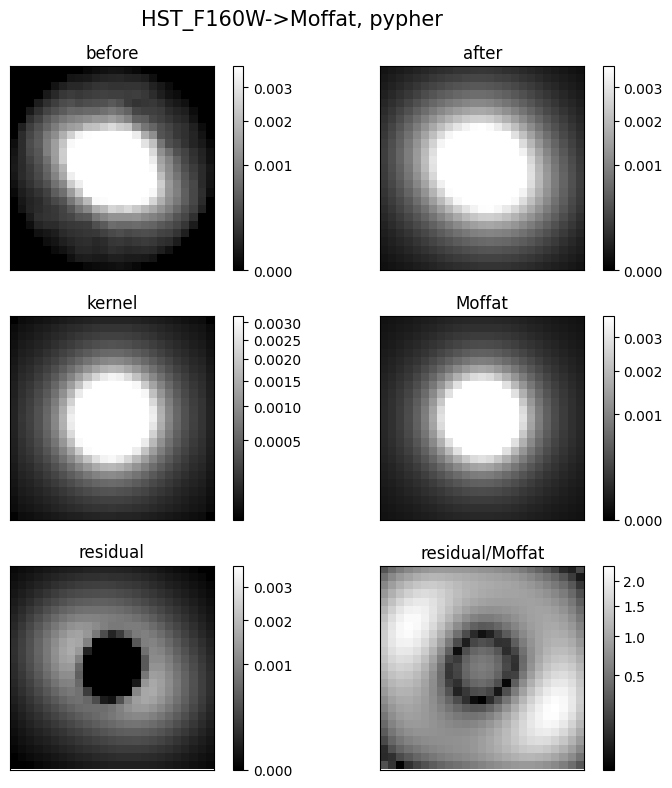

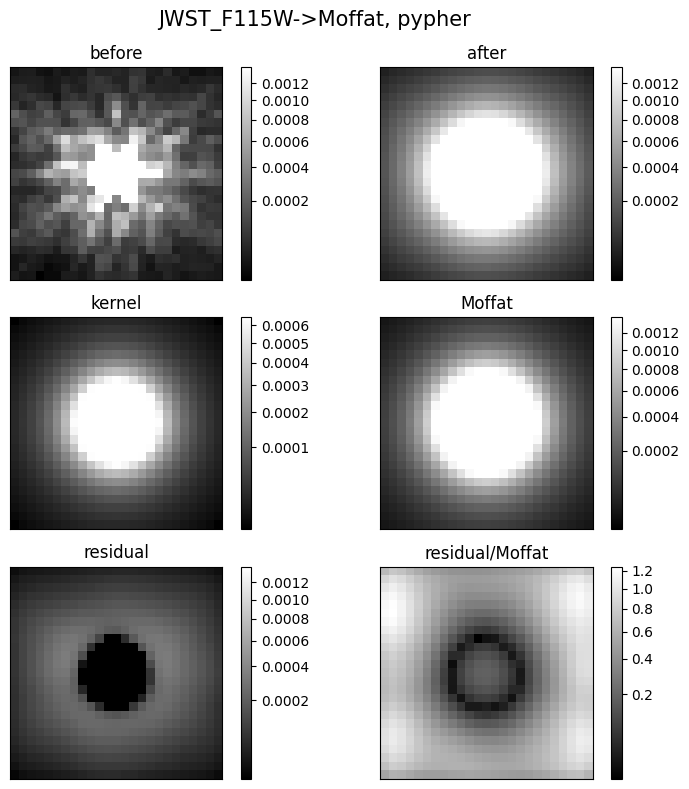

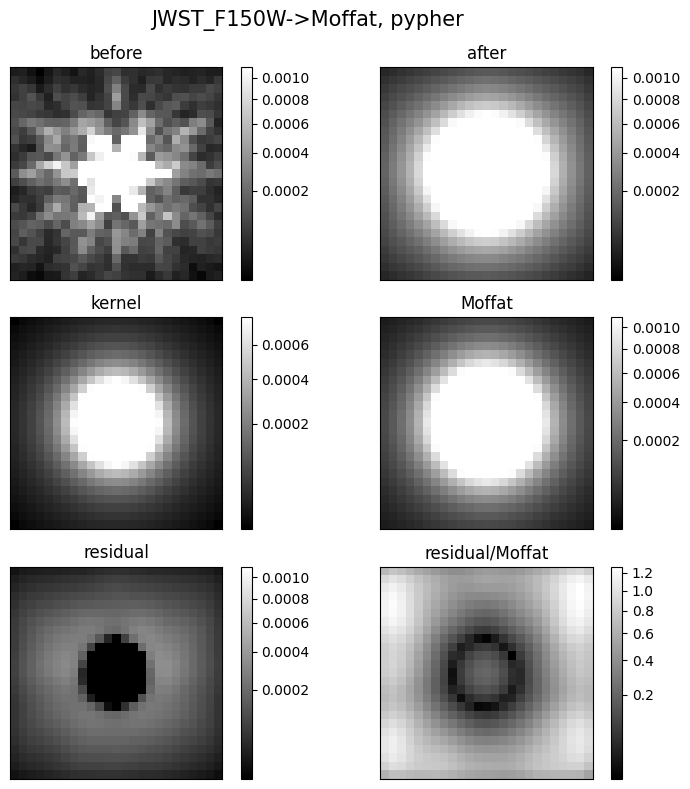

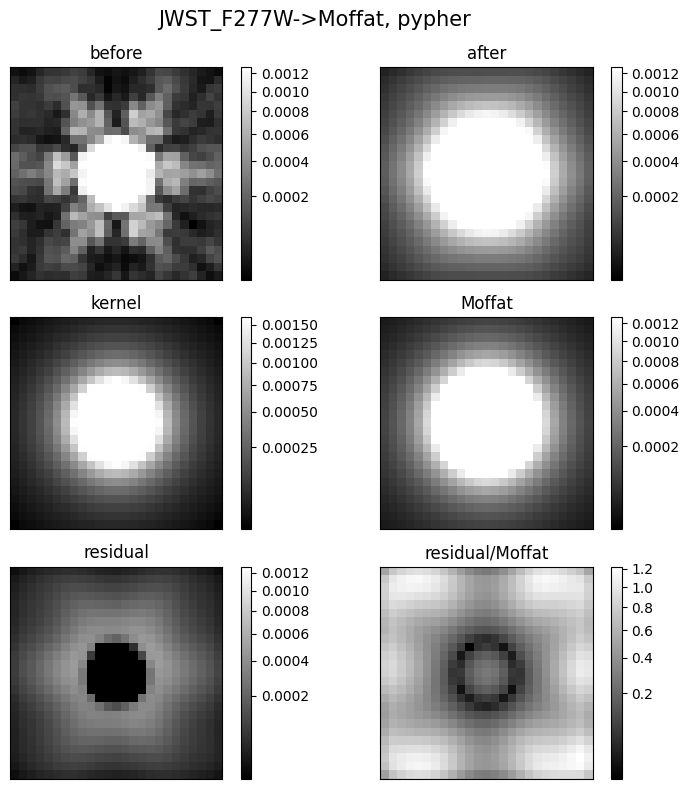

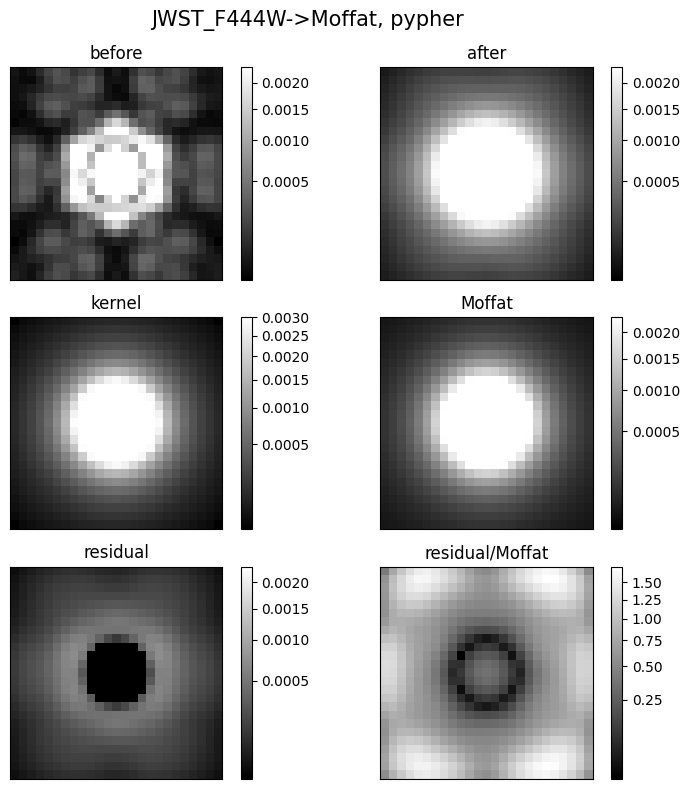

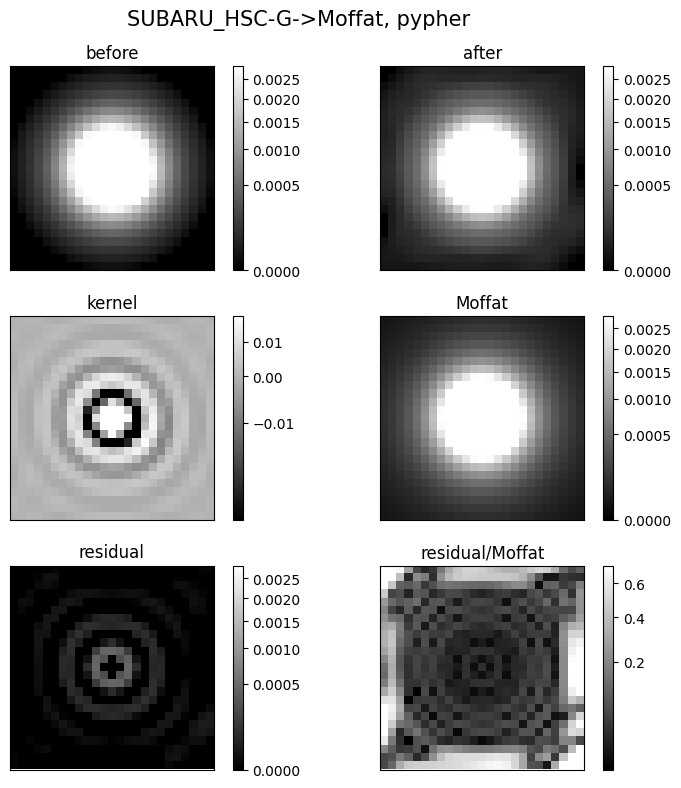

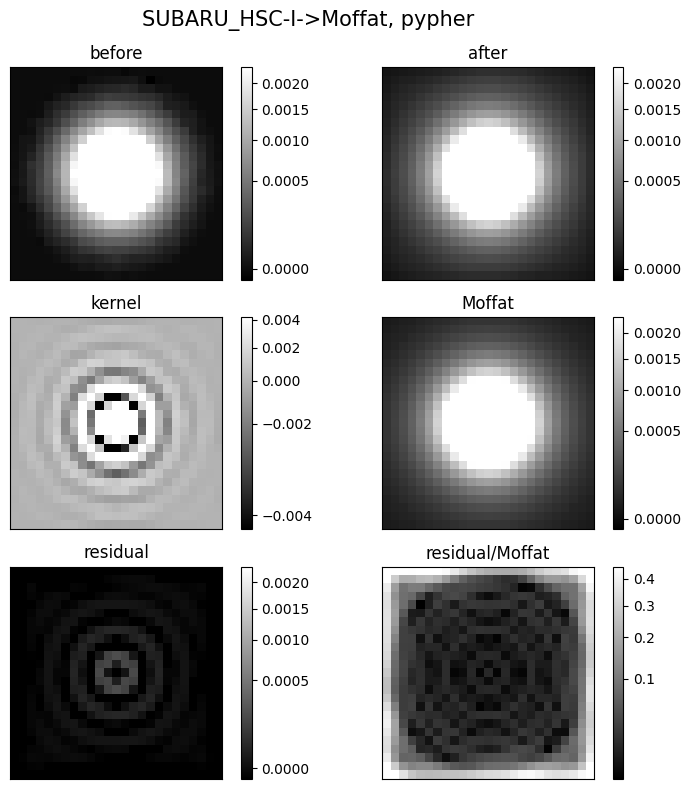

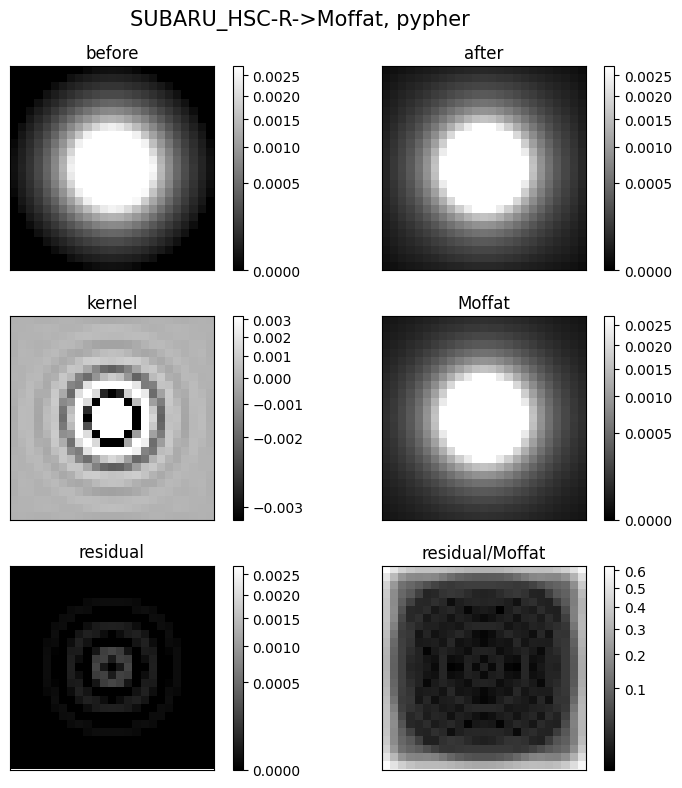

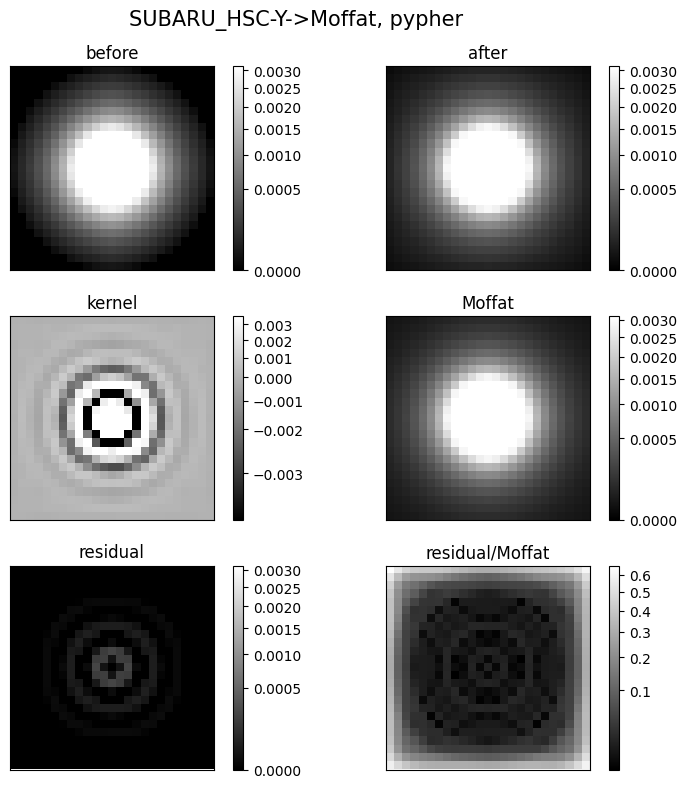

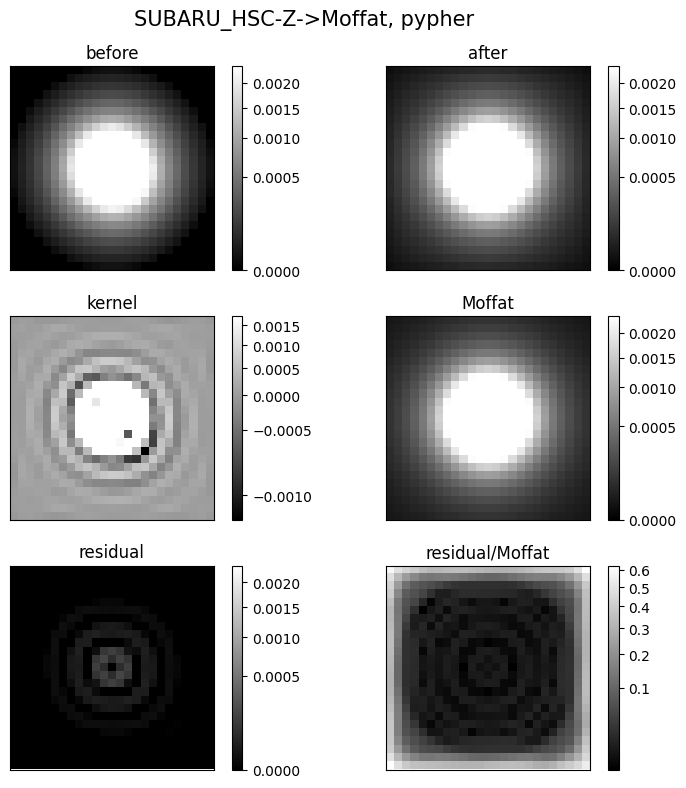

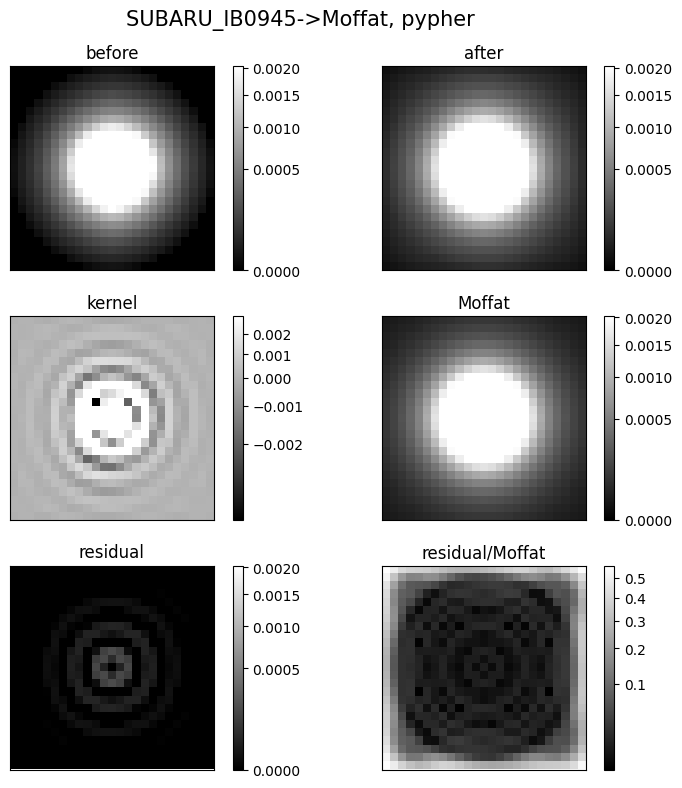

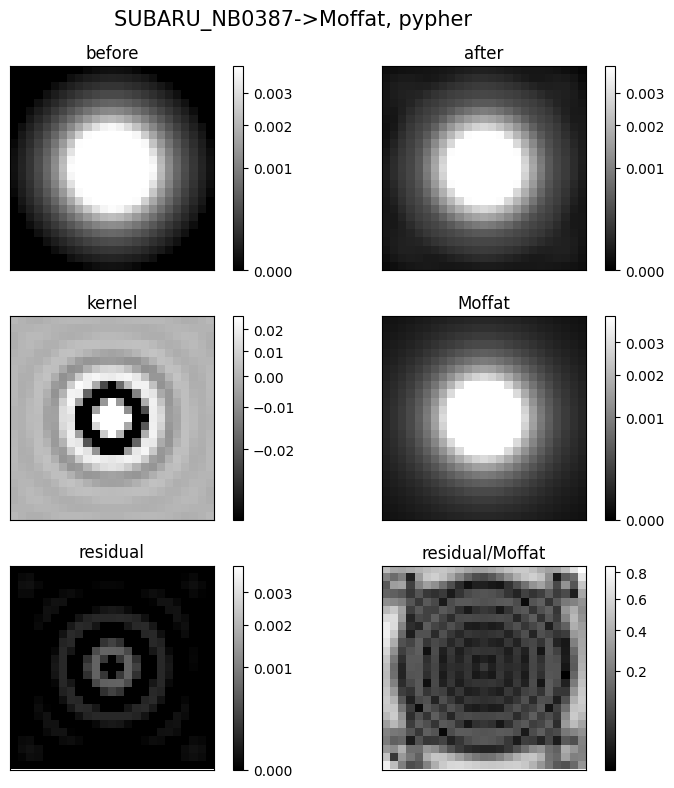

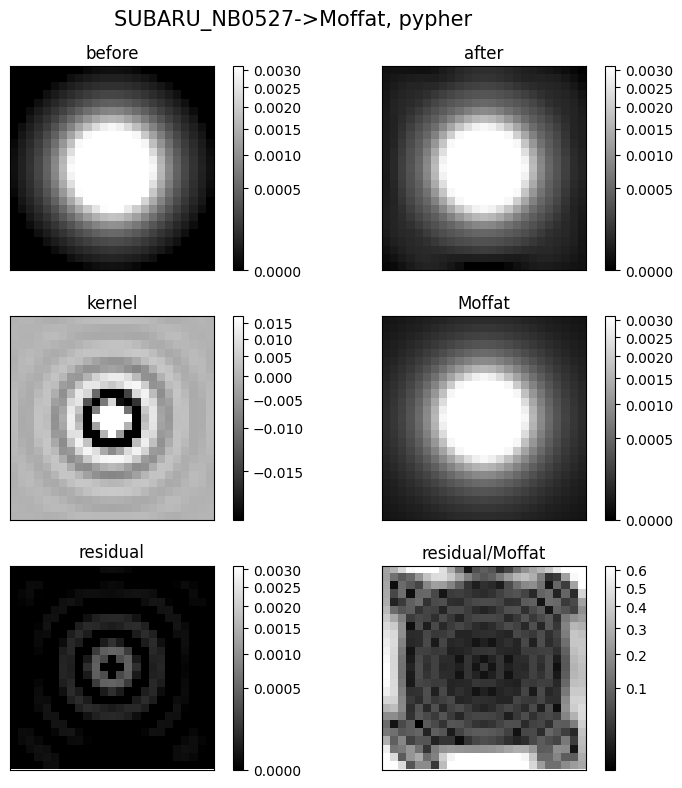

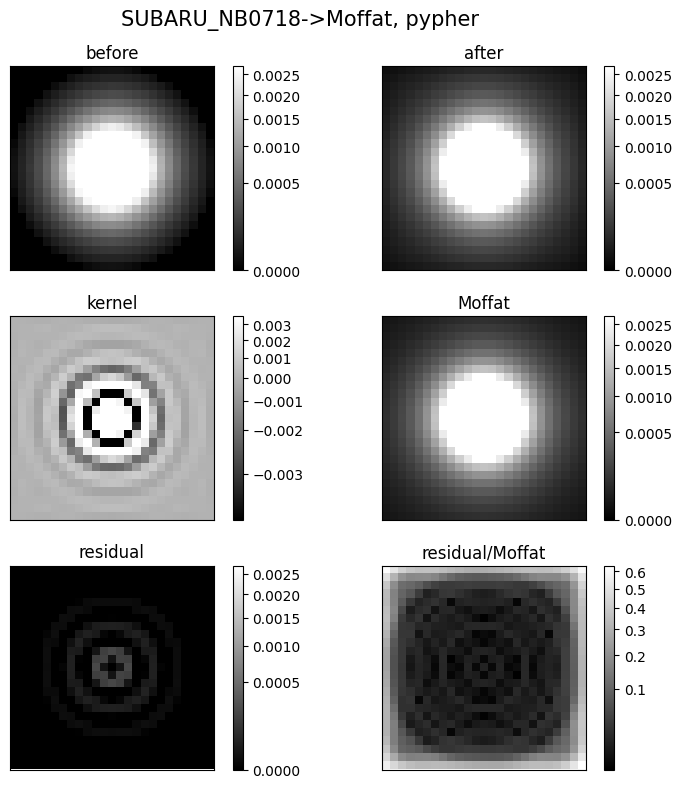

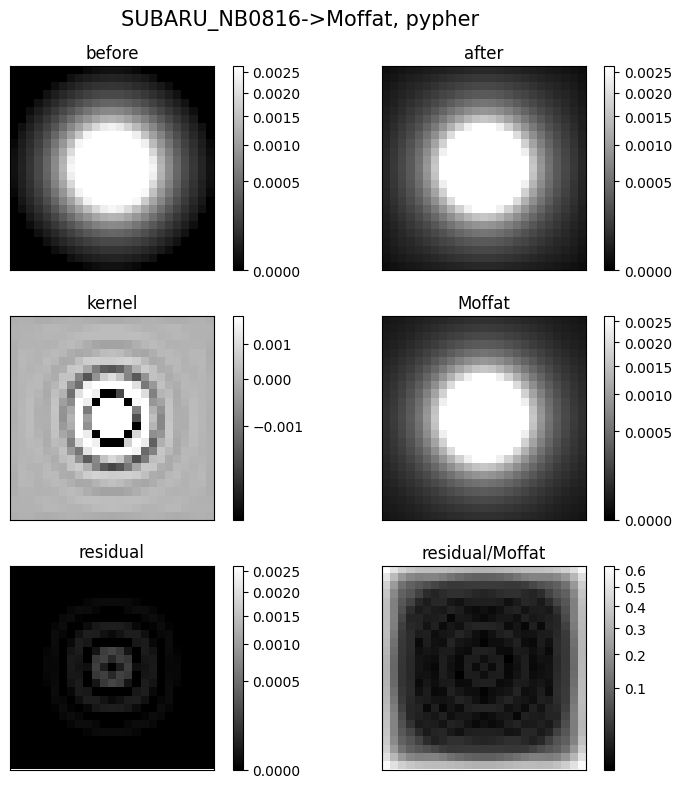

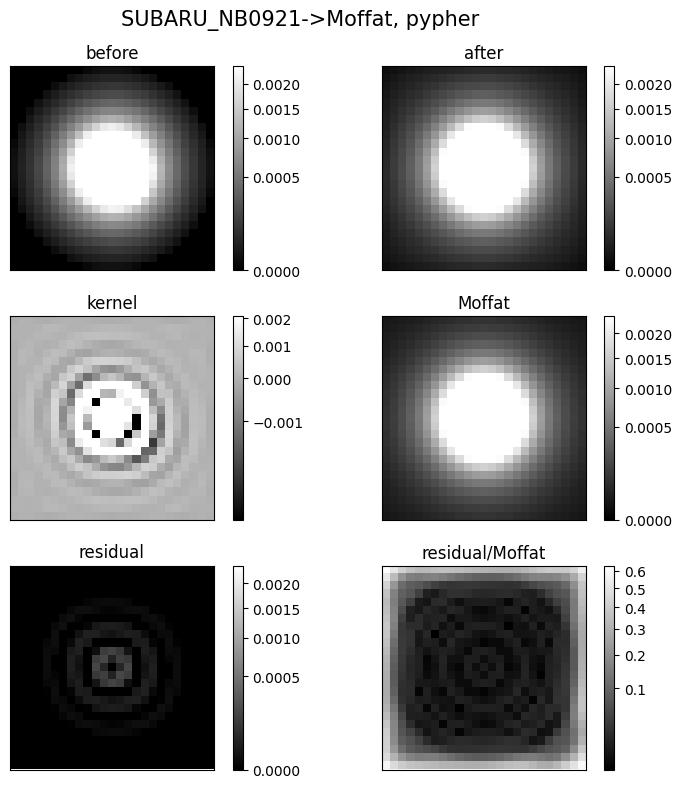

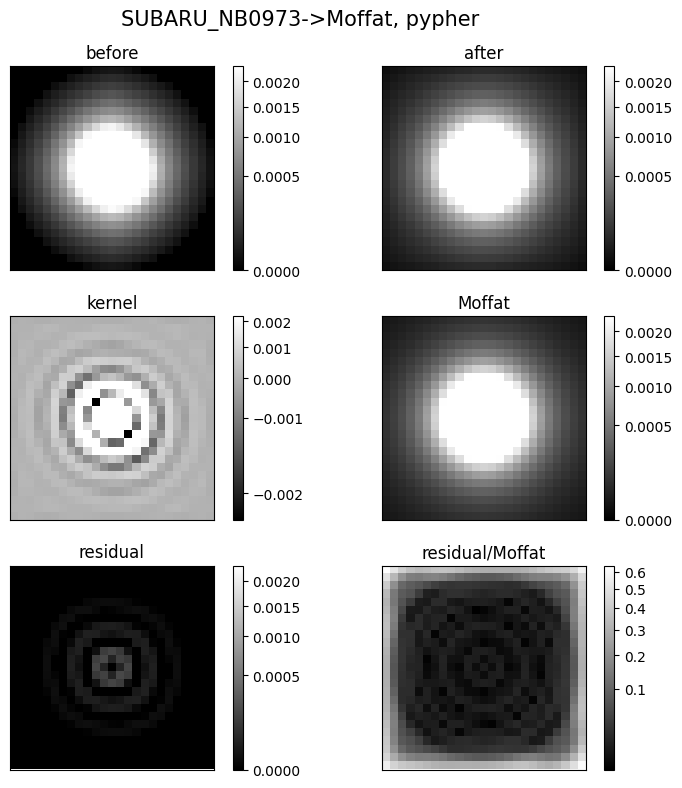

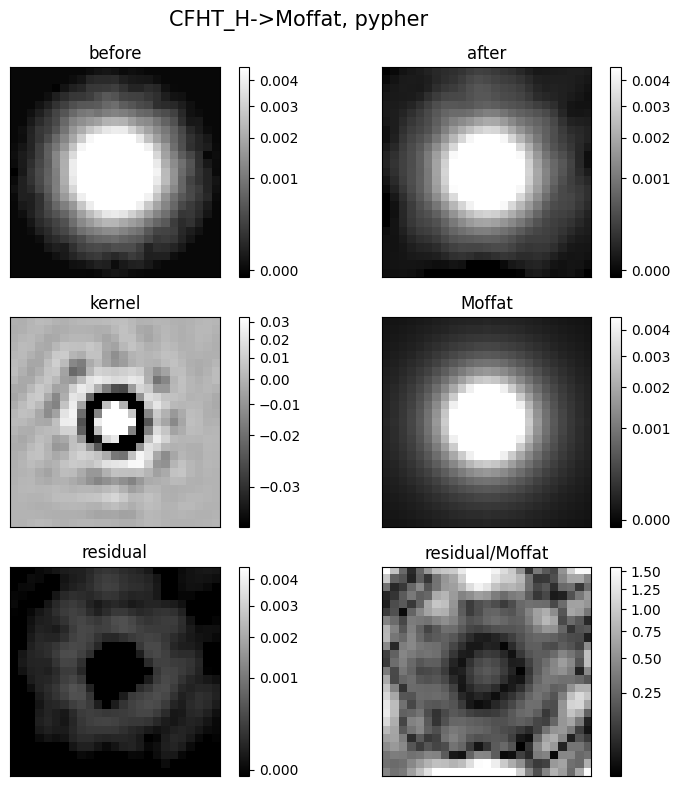

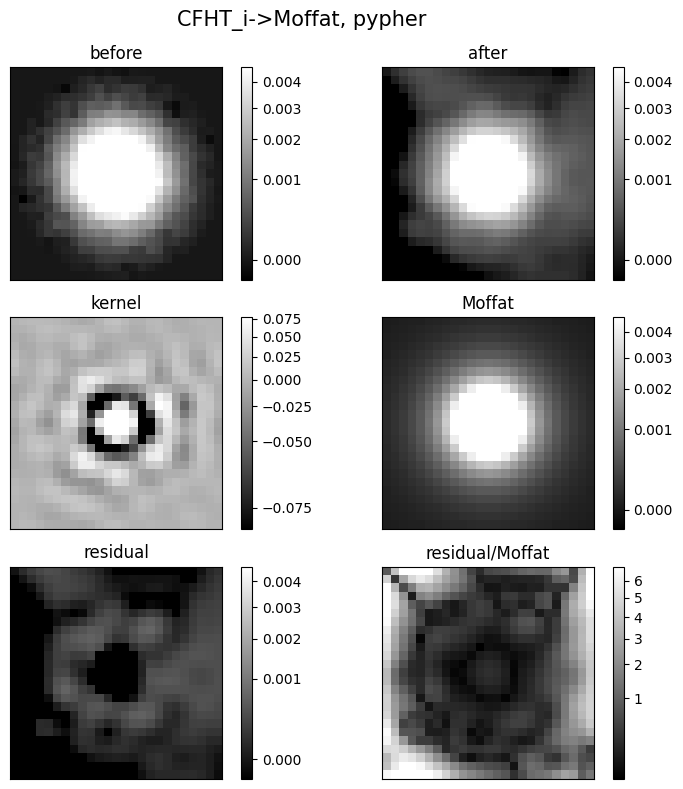

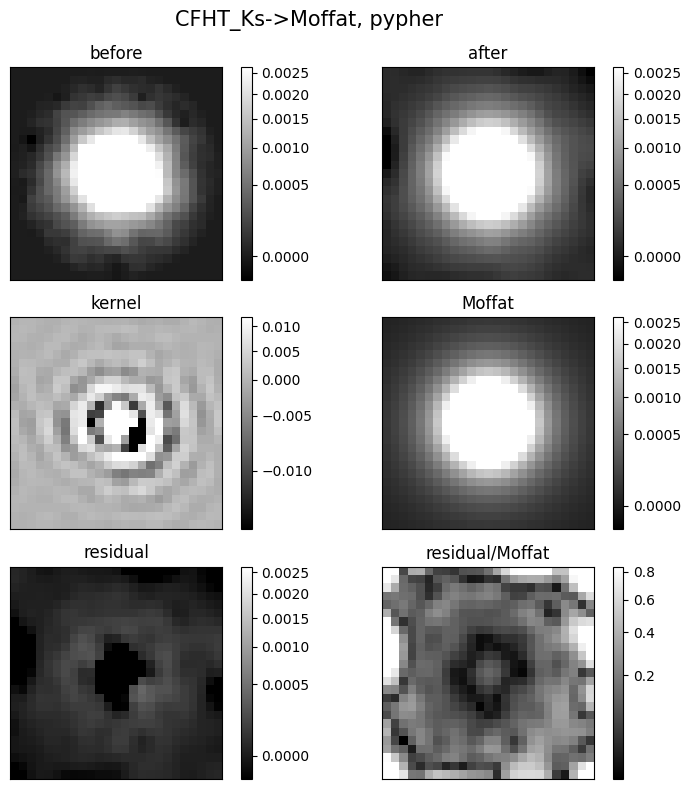

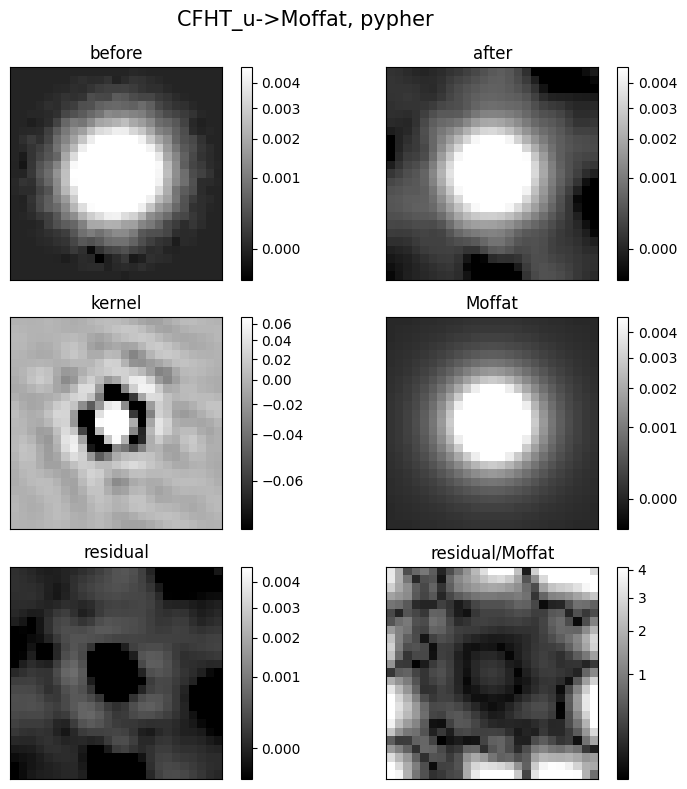

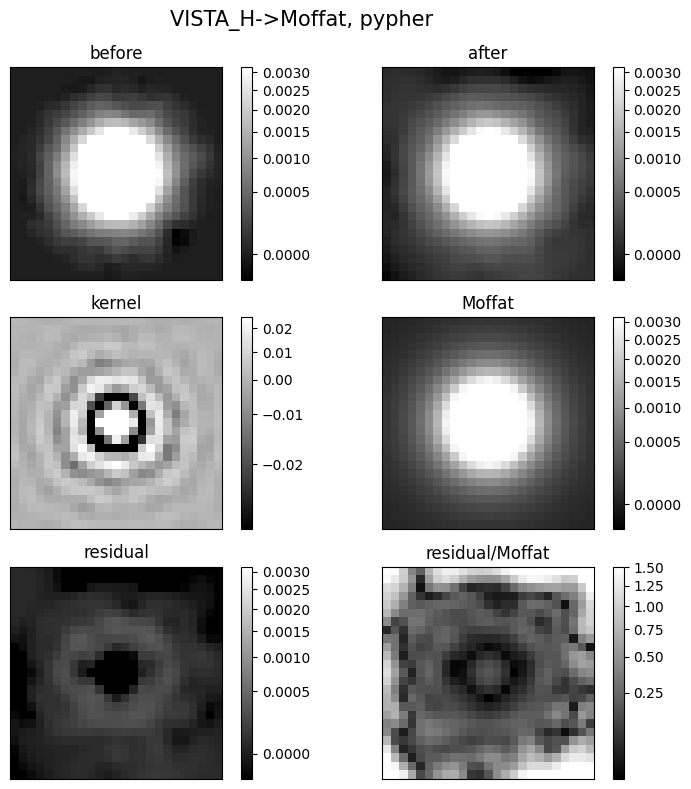

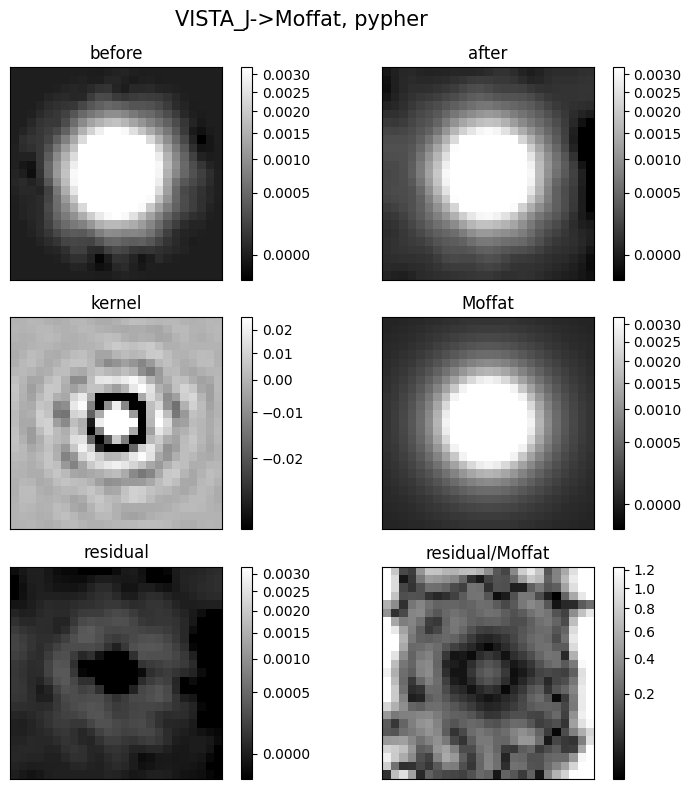

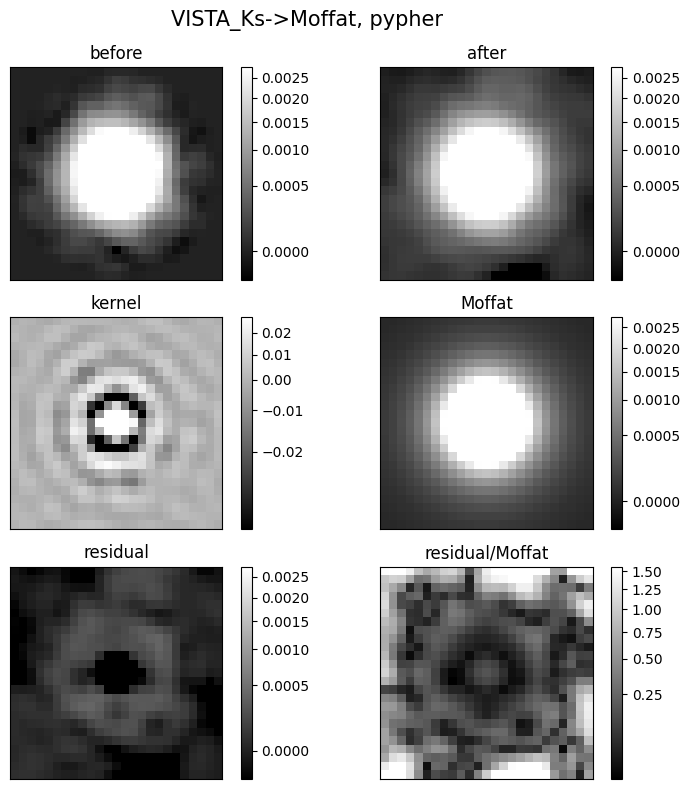

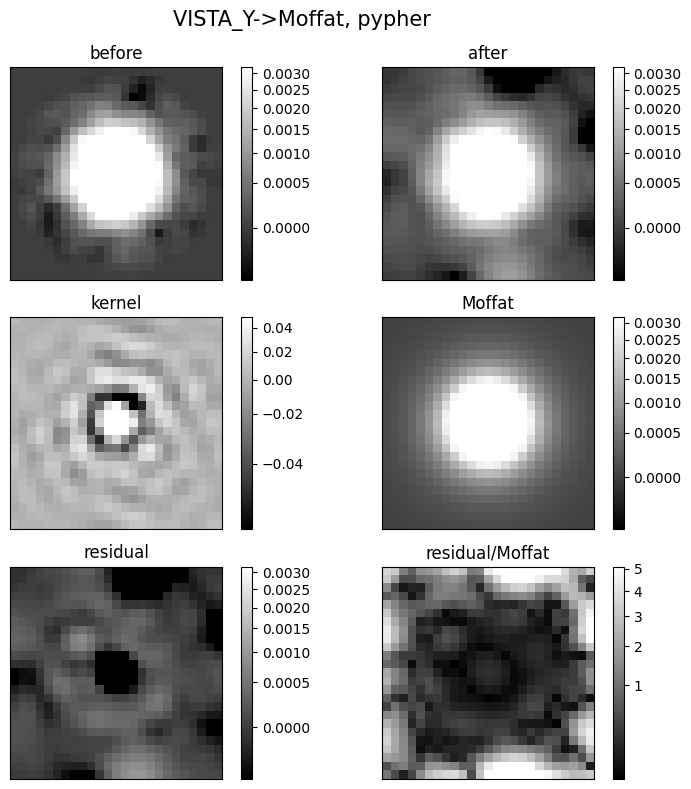

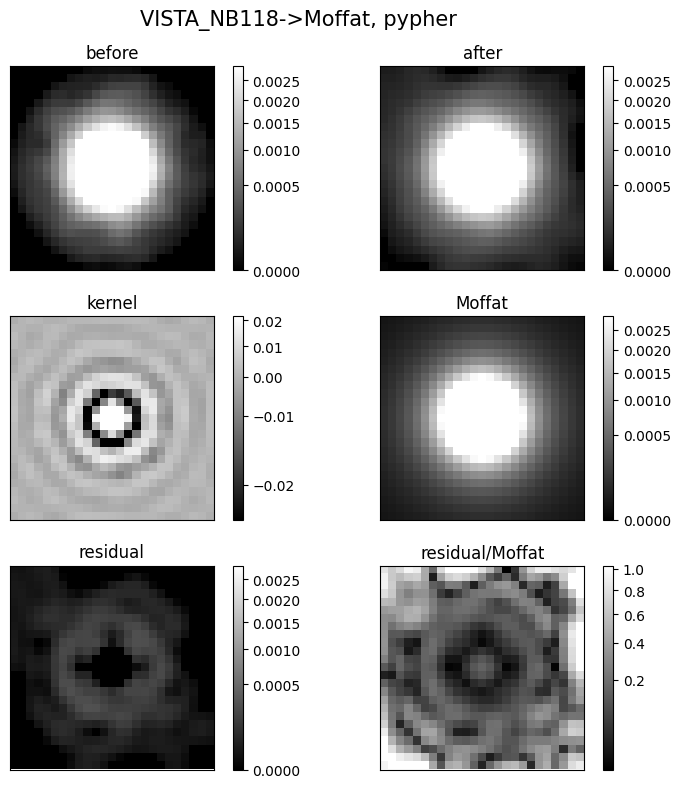

In [102]:
for tmp_flt in psfs.keys():
    if tmp_flt == 'Moffat_profile': continue
    psf_src_conv = test_psfmatching(tmp_flt, tophat_psf=False, tophat_kernel=False, mode='pypher')
    r, profile = radial_profile(psfs[tmp_flt], bins=20)
    plt.plot(r, profile, label=tmp_flt)
    r, profile = radial_profile(psfs['Moffat_profile'], bins=20)
    plt.plot(r, profile, label='Moffat')
    r, profile = radial_profile(psf_src_conv, bins=20)
    plt.plot(r, profile, label='%s (convolved)'%tmp_flt, ls='--')
    plt.yscale('log')
    # plt.xlim(0, 20)
    plt.legend()
    plt.savefig(f'/home/lupengjun/OII_emitter/photometry/output/test_conv_psf/{tmp_flt}_test_match.png')
    plt.clf()
    plt.close()

# HST and JWST match to F444W

In [111]:
kernel_path = '/home/lupengjun/OII_emitter/photometry/output/psf_space/kernels/'
tar_psf_file = '/home/lupengjun/OII_emitter/photometry/output/psf_space/psfs/NIRCam_F444W_33pix_0.05scl.fits'
for file in os.listdir('/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher'):
    if ('HST' in file or 'JWST' in file) and 'F444W' not in file:
        src_psf_file = '/home/lupengjun/OII_emitter/photometry/output/psf_for_pypher/'+file
        telescope_band = '_'.join(file.split('_')[:2])
        os.system(f'pypher {src_psf_file} {tar_psf_file} {kernel_path}kernel_{telescope_band}_to_F444W.fits -r 3.e-03')

pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F814W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F125W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F160W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F115W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F150W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_JWST_F277W_to_F444W.fits
pypher: Output kernel saved to /home/lupengjun/OII_emitter/photometry/output/psf_kernel_pypher/kernel_HST_F606W_to_F444W.fits


In [9]:
def test_psfmatching(flt, tophat_psf, tophat_kernel, mode, tar_flt='Moffat_profile'):
    #idx = filters.index(flt)
    psf_src = psfs[flt]
    psf_tar = psfs[tar_flt]

    if tophat_psf:
        window = TopHatWindow(1.)
        psf_src = window(psf_src.shape) * psf_src

    kernel = fits.getdata(f'/home/lupengjun/OII_emitter/photometry/output/psf_space/kernels/{flt}_to_F444W.fits')
    if tophat_kernel:
        window = SplitCosineBellWindow(alpha=1.1, beta=0.2) 
        kernel = window(kernel.shape) * kernel
        
    psf_src_conv = convolve_fft(psf_src, kernel, normalize_kernel=True, allow_huge=True)
    psf_src_conv = psf_src_conv / np.sum(psf_src_conv)

    fig, ax = plt.subplots(3, 2, figsize=(8,8))
    ax_imshow = []

    norm = ImageNormalize(psf_src, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[0][0].imshow(psf_src, norm=norm, cmap='gray'))
    ax[0][0].set_title('before')
    remove_tick(ax[0][0])

    ax_imshow.append(ax[0][1].imshow(psf_src_conv, norm=norm, cmap='gray'))
    ax[0][1].set_title('after')
    remove_tick(ax[0][1])

    norm_k = ImageNormalize(kernel, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[1][0].imshow(kernel, norm=norm_k, cmap='gray'))
    ax[1][0].set_title('kernel')
    remove_tick(ax[1][0])

    ax_imshow.append(ax[1][1].imshow(psf_tar, norm=norm, cmap='gray'))
    ax[1][1].set_title('F444W')
    remove_tick(ax[1][1])

    res = psf_src_conv-psf_tar
    ax_imshow.append(ax[2][0].imshow(res, norm=norm, cmap='gray'))
    ax[2][0].set_title('residual')
    remove_tick(ax[2][0])

    res = np.abs(psf_src_conv-psf_tar)/psf_tar
    norm_k = ImageNormalize(res, stretch=SqrtStretch(), interval=ZScaleInterval())
    ax_imshow.append(ax[2][1].imshow(res, norm=norm_k, cmap='gray'))
    ax[2][1].set_title('residual/F444W')
    remove_tick(ax[2][1])

    ax_flat = ax.flatten()
    for _ax in ax_flat:
        remove_tick(_ax)
    for _ax in ax_imshow:
        fig.colorbar(_ax)

    title = f'{flt}->F444W, {mode}'
    if tophat_psf:
        title += ', tophat_psf'
    fig.suptitle(title, fontsize=15) # or plt.suptitle('Main title')
    fig.tight_layout()
    plt.show()
    plt.clf()
    return psf_src_conv

In [2]:
'COSMOS_NIRCAM_F606W_median_psf.fits'.split('F')

['COSMOS_NIRCAM_', '606W_median_psf.fits']

In [40]:
psf_path = '/home/lupengjun/OII_emitter/photometry/output/psf_space/psfs/'
psfs = {}
for flt in ['F444W', 'F125W', 'F160W']:
    psfs[flt] = fits.getdata(glob(psf_path+f'*{flt}*')[0])
    print(glob(psf_path+f'*{flt}*')[0])

/home/lupengjun/OII_emitter/photometry/output/psf_space/psfs/NIRCam_F444W.fits
/home/lupengjun/OII_emitter/photometry/output/psf_space/psfs/COSMOS_NIRCAM_F125W_sum_psf.fits
/home/lupengjun/OII_emitter/photometry/output/psf_space/psfs/COSMOS_NIRCAM_F160W_sum_psf.fits


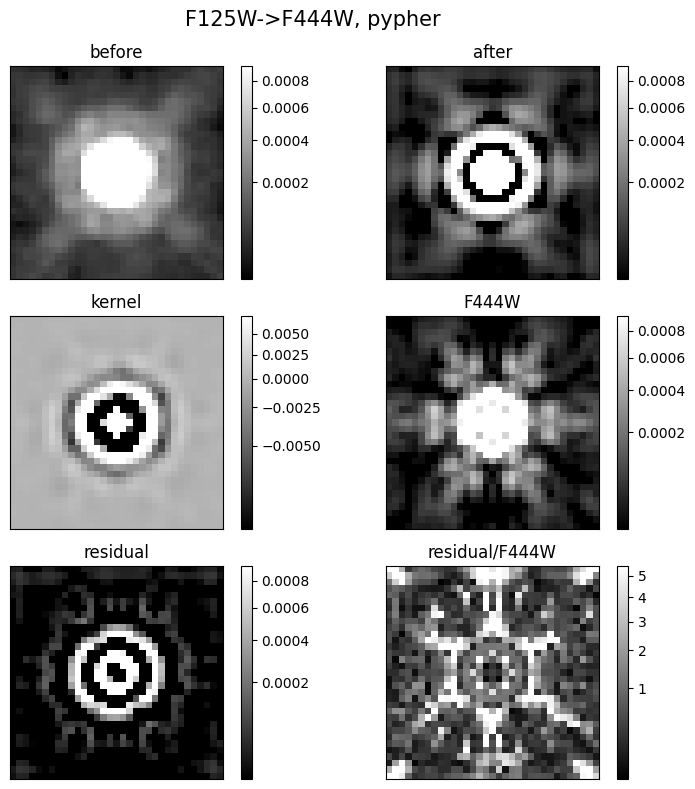

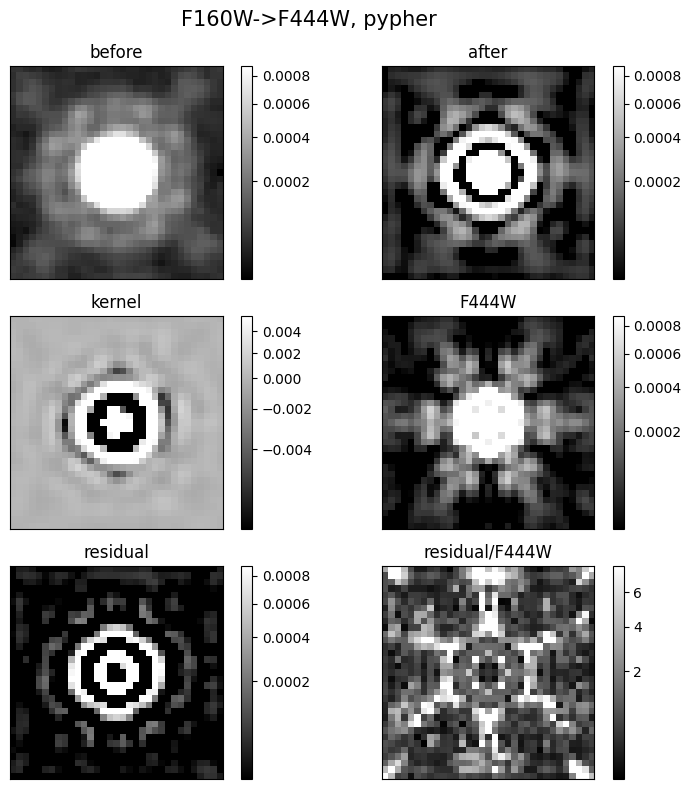

In [41]:
for tmp_flt in psfs.keys():
    if 'F444W' not in tmp_flt:
        psf_src_conv = test_psfmatching(tmp_flt, tophat_psf=False, tophat_kernel=False, mode='pypher', tar_flt='F444W')
        r, profile = radial_profile(psfs[tmp_flt], bins=20)
        plt.plot(r, profile, label=tmp_flt)
        r, profile = radial_profile(psfs['F444W'], bins=20)
        plt.plot(r, profile, label='F444W')
        r, profile = radial_profile(psf_src_conv, bins=20)
        plt.plot(r, profile, label='%s (convolved)'%tmp_flt, ls='--')
        plt.yscale('log')
        # plt.xlim(0, 20)
        plt.legend()
        plt.savefig(f'/home/lupengjun/OII_emitter/photometry/output/test_conv_psf/F444W_{tmp_flt}_test_match.png')
        plt.clf()
        plt.close()